## **Long Short-Term Memory (LSTM) network**

La siguiente figura muestra las operaciones de una celda LSTM.

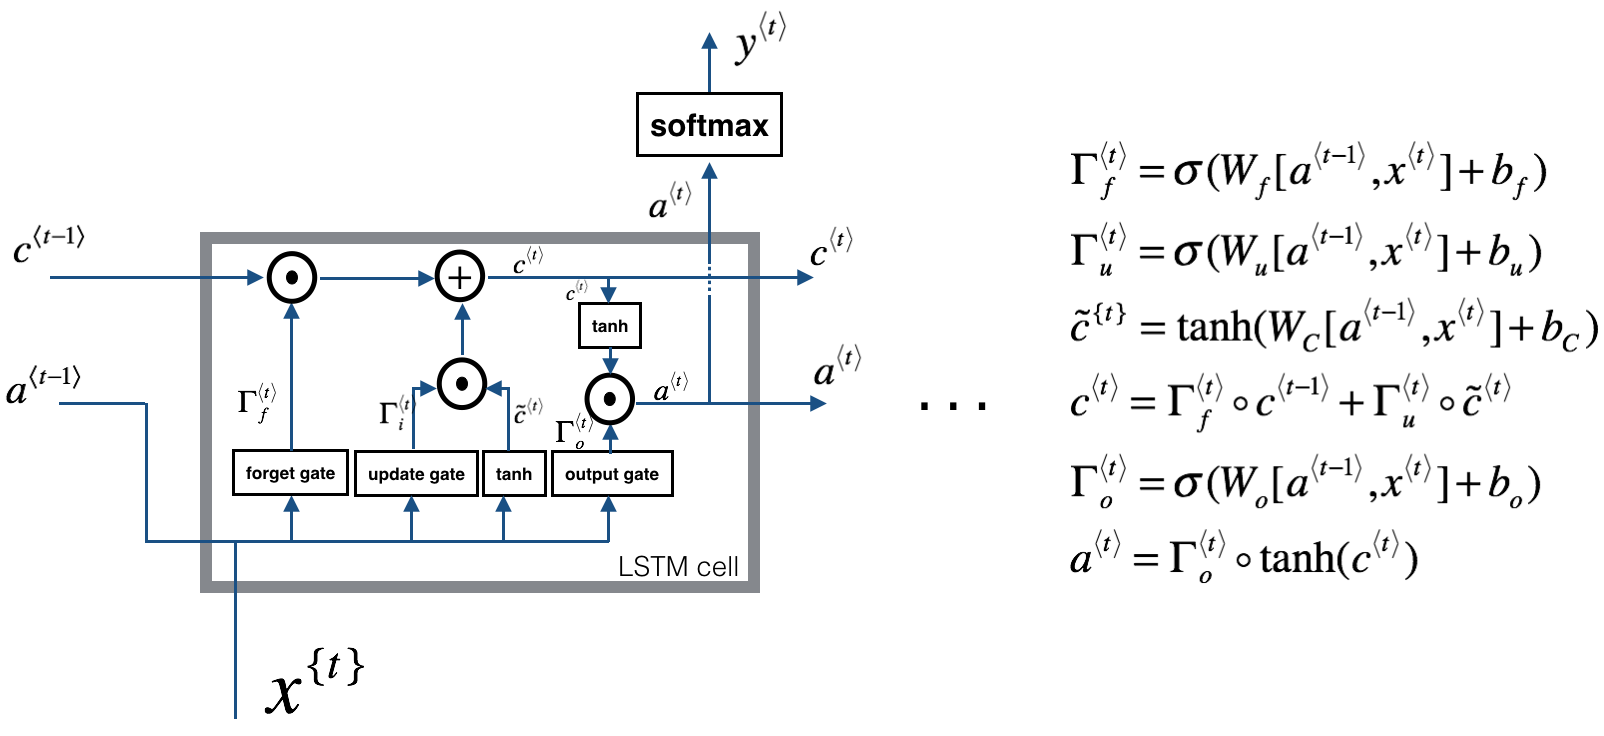

**Figura 1**: Celda LSTM. Esto rastrea y actualiza un "estado de celda" o variable de memoria c<sup>(t)</sup> en cada paso de tiempo, que puede ser diferente de a<sup>(t)</sup>.
Similar al ejemplo anterior de RNN, comenzaremos implementando la celda LSTM para un solo paso de tiempo. Luego, podemos llamarlo iterativamente desde dentro de un ciclo for para que procese una entrada con varios
pasos de tiempo.

## **Sobre las puertas**

### **- Forget gate**



Supongamos que estamos leyendo palabras en un texto y queremos usar un LSTM para realizar un seguimiento de las estructuras gramaticales, como cuando queremos saber si el sujeto es singular o plural. Si el sujeto cambia de una palabra singular a una palabra plural, necesitamos encontrar una manera de deshacernos de nuestro valor de memoria previamente almacenado del estado singular/plural. En un LSTM, la Forget gate nos permite hacer esto:

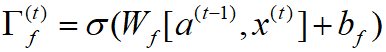

Aquí, W<sub>f</sub> son pesos que gobiernan el comportamiento de la puerta de olvido.Concatenamos [a<sup>(t-1)</sup>,x<sup>(t)</sup>] y multiplicamos por W<sub>f</sub>. La ecuación anterior resulta en un vector Γ<sup>(t)</sup><sub>f</sub> con valores entre 0 y 1. Este vector de Forget gate se multiplicará por elementos del estado previo c<sup>(t-1)</sup>. Entonces, si uno de los valores de Γ<sup>(t)</sup><sub>f</sub> es 0 (o cerca a 0) entonces significa que la LSTM debe eliminar esa información (por ejemplo, el sujeto singular) en el componente correspondiente de c<sup>(t-1)</sup>. Si uno de los valores es 1, entonces mantendrá la información.

### **- Update gate**

Una vez que olvidamos que el tema que se está discutiendo es singular, debemos encontrar una manera de actualizarlo para reflejar que el nuevo tema ahora es plural. Aquí está la fórmula para la puerta de actualización:

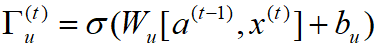

Similar a Forget gate, aquí Γ<sup>(t)</sup><sub>u</sub> es de nuevo un vector de valores entre 0 y 1. Esto se multiplicará con los elementos de c~<sup>(t)</sup> con la finalidad de calcular c<sup>(t)</sup>

### **- Actualizando la celda**

Para actualizar el nuevo sujeto, necesitamos crear un nuevo vector de números que podamos agregar a nuestro estado de celda anterior. La ecuación que usamos es:

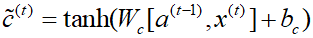

Finalmente, el nuevo estado de la celda es:

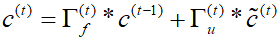

### **- Output gate**

Para decidir qué salidas usaremos, utilizaremos las siguientes dos fórmulas:

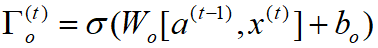

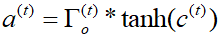

Donde en la primera ecuación se decide qué generar usando una función sigmoidea y en la última ecuación se multiplica por la *tanh* del estado anterior.

## **1 - Celda LSTM**
**Ejercicio 1.** Implementar la celda LSTM  de la Fig. 1

**Instrucciones:**


1.   Concatenar a<sup>(t-1)</sup> y x<sup>(t)</sup> en una matriz única:
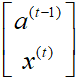
2.   Calcular todas las fórmulas anteriores
3.Calcular la predicción y<sup>(t)</sup>







In [ ]:
import numpy as np

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]

    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈3 lines)
    concat = np.zeros((n_a + n_x, m))
    concat[: n_a, :] = a_prev
    concat[n_a :, :] = xt

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)

    # Compute prediction of the LSTM cell (≈1 line)
    yt_pred = softmax(np.dot(Wy, a_next) + by)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [ ]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))


a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


## **2 - Pase adelante para LSTM**

Ahora que hemos implementado un paso de un LSTM, ahora se puede iterar usando un ciclo for para procesar una secuencia de T<sub>x</sub> entradas.

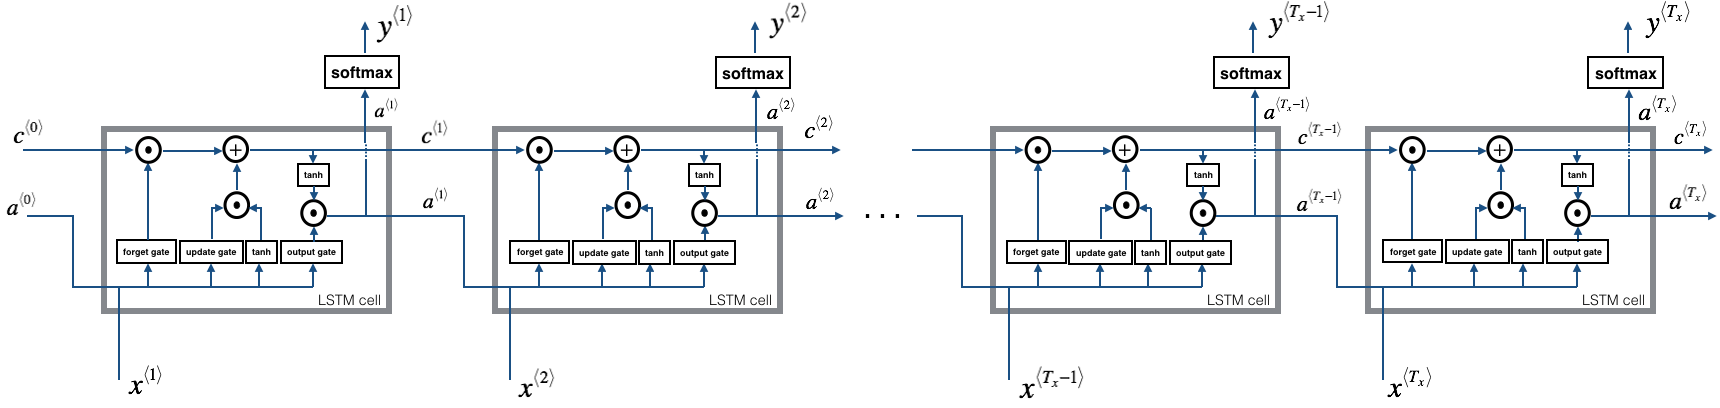

**Figura 2**: LSTM en múltiples pasos de tiempo.

**Ejercicio 2:** implemente lstm_forward() para ejecutar un LSTM en pasos de tiempo.
Notar que c<sup>(0)</sup> es inicializado en ceros

In [ ]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []

    ### START CODE HERE ###
    # Retrieve dimensions from shapes of x and Wy (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape

    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))

    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros(a_next.shape)

    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y[:,:,t] = yt
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)

    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [ ]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2
